In [3]:
import numpy as np
from ars.utils import check_overflow_underflow, h_log, h_cached

def is_log_concave(f, x_range):
    """
    Check if the function f is log-concave over the x_range.
    
    Args:
        f(function): Probability density function (maybe unnormalized)
        x_range(array_like): Range of x values to check
    
    Returns: 
        bool: Whether the function f is concave or not.
    """
    x = np.asarray(x_range)
    f_values = f(x)
    
    if np.any(f_values <= 0):
        raise ValueError("Function values must be positive.")
    
    log_f_values = np.log(f_values)
    
    # Compute second derivative
    log_f_second_derivative = np.gradient(np.gradient(log_f_values, x), x)
    
    # Check second derivative is non-positive (i.e. log-concave condition)
    is_log_concave = np.all(log_f_second_derivative <= 0)
    
    return is_log_concave

In [92]:
def construct_envelope(hull_points, h, domain):
    """
    Construct the envelope function (upper bound) from hull points.
    
    Args:
        hull_points(array-like): x-values where tangents are constructed.
        h: the log of sampling function.
        domain(tuple): (x_min, x_max), the domain boundaries of the distribution.
    
    Returns:
        pieces(list of tuples): List of (slope, intercept) for each segment.
        z_points(array_like): Start and end points of each segment.
    """
    
    if len(hull_points) < 3:
        raise ValueError("There must be at least 3 hull points.")
    
    x_min, x_max = domain
    h_values = h(hull_points)

    slopes = [(h(x+1e-5)-h(x-1e-5))/2e-5 for x in hull_points]
    intercepts = h_values - hull_points * slopes

    z_points = [x_min]
    for i in range(len(hull_points) - 1):
        slope1, intercept1 = slopes[i], intercepts[i]
        slope2, intercept2 = slopes[i + 1], intercepts[i + 1]

        if np.abs(slope1 - slope2) < 1e-10:  # Avoid numerical instability
            raise ValueError("Consecutive slopes are too close; invalid envelope.")
        z_intersect = (intercept2 - intercept1) / (slope1 - slope2)
        z_points.append(z_intersect)

    z_points.append(x_max)
    pieces = [(float(slopes[i]), float(intercepts[i])) for i in range(len(slopes))]
    return pieces, z_points

def construct_squeezing(hull_points, h, domain):
    """
    Construct the squeezing function (lower bound) from hull points.
    
    Args:
        hull_points(array-like): x-values where chords are constructed.
        h: the log of sampling function.
        domain(tuple): (x_min, x_max), the domain boundaries of the distribution.
    
    Returns:
        pieces(list of tuples): List of (slope, intercept) for each segment.
        z_points(array_like): Start and end points of each segment.
    """
    if len(hull_points) < 3:
        raise ValueError("There must be at least 3 hull points.")
    
    x_min, x_max = domain
    pieces = []
    z_points = [x_min, hull_points[0]]
    
    if x_min == -np.inf:
        pieces.append((0, -np.inf))
    else:
        x1, x2 = x_min, hull_points[0]
        slope = (h(x2)-h(x1))/ (x2 - x1)
        intercept = h(x1) - slope * x1
        pieces.append((slope, intercept))
    
    for i in range(len(hull_points)-1):
        x1, x2 = hull_points[i], hull_points[i+1]
        slope = (h(x2)-h(x1))/ (x2 - x1)
        intercept = h(x1) - slope * x1
        pieces.append((slope, intercept))
        z_points.append(x2)
    
    if x_max == np.inf:
        pieces.append((0, -np.inf))
    else:
        x1, x2 = hull_points[-1], x_max
        slope = (h(x2)-h(x1))/ (x2 - x1)
        intercept = h(x1) - slope * x1
        pieces.append((slope, intercept))
        
    z_points.append(x_max)
    
    return pieces, z_points

def calculate_piecewise_linear(x, pieces, z_points):
    """
    Calculate the value on x for a piecewise linear function.
    
    Args:
        x(float): the point we want to calculate.
        pieces(list of tuples): List of (slope, intercept) for each segment.
        z_points(array_like): Start and end points of each segment.
    
    Returns:
        (float): value of the squeezing function at x.
    """
    
    for i in range(len(pieces)):
        if x > z_points[i] and x <= z_points[i + 1]:
            slope, intercept = pieces[i]
            return intercept + slope * x

In [93]:
def update_envelope(h, orig_x_points, orig_pieces, orig_z_points, new_point):
    """
    Add a new point to the update the envelope function.
    
    Args:
        h(function): the log of sampling function f.
        orig_x_points(List): List of the original hull points.
        orig_pieces(list): List of tuples (slope, intercept) representing line segments.
        orig_z_points(list): List of the start and end of each piece.
        new_point(float): new point need to be added to be a new hull point.
        
    Returns:
        new_pieces(list of tuples): List of (slope, intercept) for each segment.
        new_z_points(array_like): Start and end points of each segment.
    """
    domain_min, domain_max = orig_z_points[0], orig_z_points[-1]
    if new_point <= domain_min or new_point >= domain_max:
        raise ValueError(f"New point is out of the domain of the function.")
    
    new_slope = (h(new_point+1e-5) - h(new_point-1e-5))/2e-5
    new_intercept = h(new_point) - new_point * new_slope
    if domain_min < new_point <= orig_x_points[0]:
        if new_point == orig_x_points[0]:
            print("New points already in the hull points.")
            return orig_pieces, orig_z_points
        ## calculate new z point
        slope, intercept = orig_pieces[0]
        z =  -(intercept - new_intercept) / (slope - new_slope)
        orig_z_points.insert(1, z)
        ## insert new piece
        orig_pieces.insert(0, (new_slope, new_intercept))
        return orig_pieces, orig_z_points
    
    for i in range(len(orig_x_points)-1):
        if orig_x_points[i] < new_point <= orig_x_points[i+1]:
            if new_point == orig_x_points[i+1]:
                print("New points already in the hull points.")
                return orig_pieces, orig_z_points

            ## calculate new z_points
            slope1, intercept1 = orig_pieces[i]
            slope2, intercept2 = orig_pieces[i+1]
            z1 = -(intercept1 - new_intercept) / (slope1 - new_slope)
            z2 = -(intercept2 - new_intercept) / (slope2 - new_slope)
            orig_z_points[i+1] = z2
            orig_z_points.insert(i+1, z1)
            ## insert new piece
            orig_pieces.insert(i+1, (new_slope, new_intercept))
            return orig_pieces, orig_z_points
    
    if orig_x_points[-1] < new_point < domain_max:
        ## calculate new z point
        slope, intercept = orig_pieces[0]
        z = -(intercept - new_intercept) / (slope - new_slope)
        orig_z_points.insert(-1, z)
        ## insert new piece
        orig_pieces.append((new_slope, new_intercept))
        return orig_pieces, orig_z_points

def update_squeezing(h, orig_pieces, orig_z_points, new_point):
    """
    Add a new point to the update the squeezing function.
    
    Args:
        h(function): the log of sampling function f.
        orig_pieces(list): List of tuples (slope, intercept) representing line segments.
        orig_z_points(list): List of the start and end of each piece.
        new_point(float): new point need to be added to be a new hull point.
        
    Returns:
        new_pieces(list of tuples): List of (slope, intercept) for each segment.
        new_z_points(array_like): Start and end points of each segment.
    """
    domain_min, domain_max = orig_z_points[0], orig_z_points[-1]
    if new_point <= domain_min or new_point >= domain_max:
        raise ValueError(f"New point is out of the domain of the function.")
    
    for i in range(len(orig_z_points)-1):
        if orig_z_points[i] < new_point <= orig_z_points[i+1]:
            if new_point == orig_z_points[i+1]:
                print("New points already in the hull points.")
                return orig_pieces, orig_z_points
            ## insert new piece
            slope1 = (h(new_point) - h(orig_z_points[i]))/(new_point - orig_z_points[i])
            intercept1 = h(new_point) - slope1 * new_point
            slope2 = (h(new_point) - h(orig_z_points[i+1]))/(new_point - orig_z_points[i+1])
            intercept2 = h(new_point) - slope2 * new_point
            orig_pieces[i] = (slope1, intercept1)
            orig_pieces.insert(i+1, (slope2, intercept2))
            ## insert new z point
            orig_z_points.insert(i+1, new_point)
            return orig_pieces, orig_z_points
            
h = lambda x: -0.5 * x**2
hull_points = np.linspace(-5,5,5)
print(hull_points)
domain = (-10, 10)
orig_env_pieces, orig_env_z_points = construct_envelope(hull_points, h, domain)
orig_squ_pieces, orig_squ_z_points = construct_squeezing(hull_points, h, domain)
print(orig_env_pieces)
print("\n")
print(orig_env_z_points)
print("\n")
print(orig_squ_pieces)
print("\n")
print(orig_squ_z_points)
print("New:")
new_point = 1

new_env_pieces, new_env_z_points = update_envelope(h, hull_points, orig_env_pieces, orig_env_z_points, new_point)
new_squ_pieces, new_squ_z_points = update_squeezing(h, orig_squ_pieces, orig_squ_z_points, new_point)

print(new_env_pieces)
print("\n")
print(new_env_z_points)
print("\n")
print(new_squ_pieces)
print("\n")
print(new_squ_z_points)

[-5.  -2.5  0.   2.5  5. ]
[(4.999999999810711, 12.499999999053557), (2.500000000016378, 3.125000000040945), (0.0, -0.0), (-2.500000000016378, 3.125000000040945), (-4.999999999810711, 12.499999999053557)]


[-10, np.float64(-3.7499999999135447), np.float64(-1.250000000008189), np.float64(1.250000000008189), np.float64(3.7499999999135447), 10]


[(np.float64(7.5), np.float64(25.0)), (np.float64(3.75), np.float64(6.25)), (np.float64(1.25), np.float64(0.0)), (np.float64(-1.25), np.float64(0.0)), (np.float64(-3.75), np.float64(6.25)), (np.float64(-7.5), np.float64(25.0))]


[-10, np.float64(-5.0), np.float64(-2.5), np.float64(0.0), np.float64(2.5), np.float64(5.0), 10]
New:
[(4.999999999810711, 12.499999999053557), (2.500000000016378, 3.125000000040945), (0.0, -0.0), (-1.000000000001, 0.5000000000010001), (-2.500000000016378, 3.125000000040945), (-4.999999999810711, 12.499999999053557)]


[-10, np.float64(-3.7499999999135447), np.float64(-1.250000000008189), 0.5000000000005, 1.750000000008

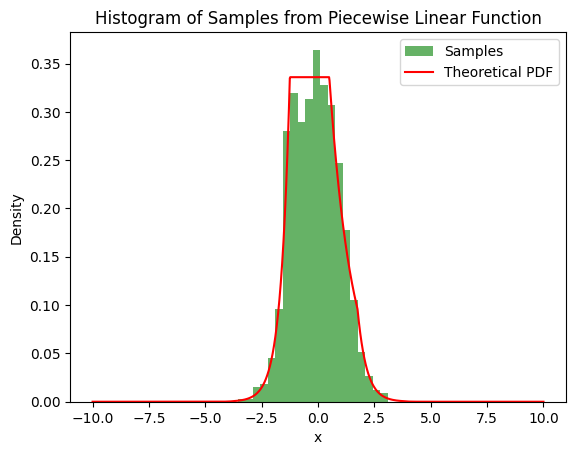

In [94]:
def sample_piecewise_linear(pieces, z_points):
    """
    Sample from the exponential of a piecewise linear function.
    
    Args:
        pieces: List of tuples (slope, intercept) representing line segments.
        z_points: List of the start and end of each piece.
    
    Returns:
        A sampled point from the exponential of piecewise linear function.
    """
    # Input checks
    if len(z_points) != len(pieces) + 1:
        raise ValueError(f"Length of `z_points` ({len(z_points)}) should be length of `pieces` ({len(pieces)}) + 1")

    areas, cumulative_areas = [], [0]
    
    for i, (slope, intercept) in enumerate(pieces):
        x_start, x_end = z_points[i], z_points[i + 1]
        if slope == 0:
            area = np.exp(intercept) * (x_end - x_start)
        else:
            log_start = intercept + slope * x_start
            log_end = intercept + slope * x_end
            area = (np.exp(log_end) - np.exp(log_start)) / slope
        areas.append(area)
        cumulative_areas.append(cumulative_areas[-1] + area)

    total_area = cumulative_areas[-1]
    
    # Sample a uniform random value in [0, total_area] to pick a segment
    u = np.random.uniform(0, total_area)
    # Find the segment corresponding to the sampled area
    segment = np.searchsorted(cumulative_areas, u) - 1
    slope, intercept = pieces[segment]
    x_start, x_end = z_points[segment], z_points[segment + 1]

    if slope == 0:
        return np.random.uniform(x_start, x_end)
    else:
        cdf_start = np.exp(np.clip(intercept + slope * x_start, -700, 700)) / slope
        cdf_sample = cdf_start + u - cumulative_areas[segment]
        return (np.log(cdf_sample * slope) - intercept) / slope
    
    
import matplotlib.pyplot as plt
pieces = new_env_pieces
z_points = new_env_z_points
samples = [sample_piecewise_linear(pieces, z_points) for _ in range(1000)]

plt.hist(samples, bins=20, density=True, alpha=0.6, color='g', label='Samples')
plt.title('Histogram of Samples from Piecewise Linear Function')
plt.xlabel('x')
plt.ylabel('Density')

x_vals = np.linspace(-10, 10, 1000)
y_vals = np.zeros_like(x_vals)
area = 0
for i, (slope, intercept) in enumerate(pieces):
    mask = (x_vals >= z_points[i]) & (x_vals < z_points[i + 1])
    y_vals[mask] = np.exp(intercept + slope * x_vals[mask])
    if slope == 0:
        area += np.exp(intercept)*(z_points[i+1]-z_points[i])
    else:
        area += (np.exp(slope * z_points[i+1] + intercept) - np.exp(slope * z_points[i] + intercept))/ slope

plt.plot(x_vals, y_vals / area , 'r-', label='Theoretical PDF')
plt.legend()
plt.show()


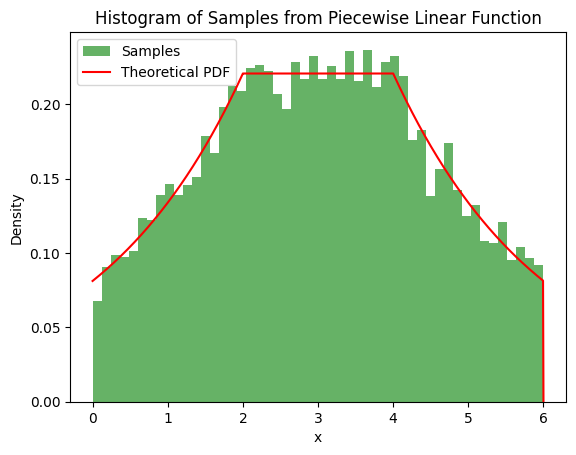

In [95]:
import matplotlib.pyplot as plt
# Test inputs for the piecewise linear function
pieces = [(0.5, 1), (0, 2), (-0.5, 4)]  # (slope, intercept)
z_points = [0, 2, 4, 6]  # x-values defining the start and end of each segment

# Sampling 10 points
samples = [sample_piecewise_linear(pieces, z_points) for _ in range(10000)]

# Plotting the histogram of sampled points
plt.hist(samples, bins=50, density=True, alpha=0.6, color='g', label='Samples')
plt.title('Histogram of Samples from Piecewise Linear Function')
plt.xlabel('x')
plt.ylabel('Density')

# Plot the theoretical exponential of piecewise linear function
x_vals = np.linspace(0, 6, 1000)
y_vals = np.zeros_like(x_vals)

for i, (slope, intercept) in enumerate(pieces):
    mask = (x_vals >= z_points[i]) & (x_vals < z_points[i + 1])
    y_vals[mask] = np.exp(intercept + slope * x_vals[mask])

area = 4 * (np.exp(2) - np.exp(1)) + 2 * np.exp(2)
plt.plot(x_vals, y_vals / area , 'r-', label='Theoretical PDF')
plt.legend()
plt.show()

In [58]:
def adaptive_search_domain(f, start=0, step=0.1, threshold=1e-15, max_steps=int(1e6)):
    """
    Search the domain of the given function.
    
    Args:
    - f(function): Given function we want to search for domain of. 
    - start(float): Starting searching point.
    - step(float): Searching step.
    - threshold(float): Threshold to judge whether the function value is too small.
    - max_steps(int): maximum searching steps.
    
    Returns:
    - domain_start, domain_end(float): The searching domain of the function.
    """
    
    x = start
    domain_points = []
    
    # Searching towards the positive side
    for _ in range(max_steps):
        if f(x) > threshold:
            domain_points.append(x)
        x += step
    
    x = start
    
    # Searching towards the negative side
    for _ in range(max_steps):
        if f(x) > threshold:
            domain_points.append(x)
        else:
            break
        x -= step
    
    if not domain_points:
        raise ValueError("Cannot find the domain in the region, please check your function or change the argument max_steps.")
    return min(domain_points), max(domain_points)

# Gaussian
f = lambda x: np.exp(-x**2)
domain = adaptive_search_domain(f)
print(f"Adaptive searching domain: {domain}")

Adaptive searching domain: (-5.799999999999995, 5.799999999999995)


In [83]:
def init_points(f, domain, threshold = 1e-5):
    """
    Search the initial point of the .
    
    Args:
    - f(function): Given function. 
    - domain(tuple): domain of the function.
    - threshold(float): Threshold to judge whether to be the initial point.
    
    Returns:
    - init_1, init_2(tuple): Two initial points.
    """
    
    domain_min, domain_max = domain
    step = (domain_max - domain_min) / 1000
    
    init_1 = domain_min
    while f(init_1) <= threshold:
        init_1 += step
    
    init_2 = domain_max
    while f(init_2) <= threshold:
        init_2 -= step
        
    return init_1, init_2  

f = lambda x: np.exp(-x**2)
domain = adaptive_search_domain(f)
init = init_points(f, domain)
print(init)

(-3.391999999999996, 3.391999999999996)


Starting ARS ...
Searching for the domain ...
(-8.299999999999986, 8.299999999999986)
Checking if the function is log-concave ...
[-4.7974     -3.73131111 -2.66522222 -1.59913333 -0.53304444  0.53304444
  1.59913333  2.66522222  3.73131111  4.7974    ]
Iteration 0: u = 0.8576155168806313, x_star = 1.1438920707195286
Update
Iteration 1: u = 0.16510137899630017, x_star = -0.34247729416326356
Accepted
Iteration 2: u = 0.3700712044956813, x_star = 1.0157623986542728
Accepted
Iteration 3: u = 0.6557855681143573, x_star = -2.901780317981678
Accepted
Iteration 4: u = 0.2884211408668592, x_star = 1.122002586732758
Accepted
Iteration 5: u = 0.9815610197010257, x_star = 0.9814586258648065
Update
Iteration 6: u = 0.9219610417592342, x_star = -0.2321848167320705
Update
Iteration 7: u = 0.995660901717809, x_star = 1.0969485103803247
Accepted
Iteration 8: u = 0.1932556589372747, x_star = 0.4046054149483235
Accepted
Iteration 9: u = 0.5897668464021012, x_star = 0.12304632976493741
Accepted
Iteration 

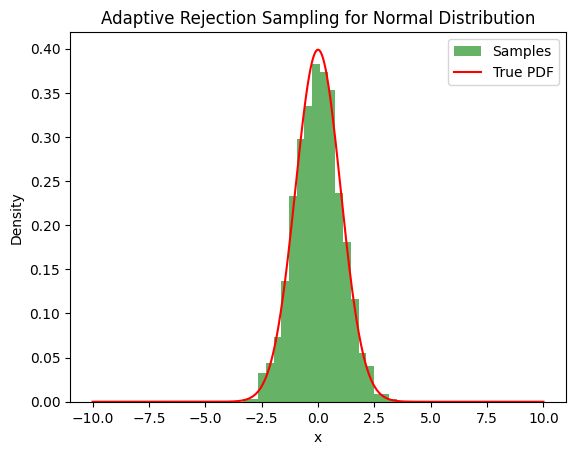

In [115]:
def ars(f, num_samples, domain = (-np.inf, np.inf), domain_threshold = 1e-15, domain_step = 0.1, max_step = int(1e6), burn_in=1000, init_threshold = 1e-5 ,num_init_points=10):
    """
    Adaptive Rejection Sampling with intelligent initialization and overflow protection.

    Args:
        f (function): Target probability density function.
        num_samples (int): Number of samples to generate.
        domain (tuple): Range of the distribution.
        domian_threshold(float): Threshold to judge whether the function value is too small.
        domain_step(float): step size in adaptive domain search.
        max_step(int): max step in adaptive domain search
        burn_in (int): Number of initial samples to discard.
        init_threshold(float): threshold to find the initial points
        num_init_points (int): Number of initial points for constructing envelope( must be >=3).

    Returns:
        np.array: Array of sampled points.
    """
    
    print("Starting ARS ...")
    print("Searching for the domain ...")
    if domain == (-np.inf, np.inf):
        domain = adaptive_search_domain(f, threshold = domain_threshold)
    print(domain)
    print("Checking if the function is log-concave ...")
    if not is_log_concave(f, np.linspace(*domain, 1000)):
        raise ValueError("The input function is not log-concave!")

    h = lambda x: h_log(f, x)
    
    init_1, init_2 = init_points(f, domain, threshold = init_threshold)
    x_points = np.linspace(init_1, init_2, num_init_points)
    print(x_points)
    samples = []
    envelope_pieces, envelope_points = construct_envelope(x_points, h, domain)
    squeezing_pieces, squeezing_points = construct_squeezing(x_points, h, domain)
    i = 0
    while len(samples) <= (num_samples + burn_in-1):
        # Sample from the envelope
        x_star = sample_piecewise_linear(envelope_pieces, envelope_points)
        u = np.random.uniform()
        print(f"Iteration {i}: u = {u}, x_star = {x_star}")

        # Check acceptance criteria
        if u <= np.exp(calculate_piecewise_linear(x_star, squeezing_pieces, squeezing_points) - calculate_piecewise_linear(x_star, envelope_pieces, envelope_points)):  # Check lower bound
            samples.append(x_star)
            print("Accepted")
        elif u <= np.exp(h(x_star) - calculate_piecewise_linear(x_star, envelope_pieces, envelope_points)):
            samples.append(x_star)
            print("Update")
            envelope_pieces, envelope_points = update_envelope(h, x_points, envelope_pieces, envelope_points, x_star)
            squeezing_pieces, squeezing_points = update_squeezing(h, squeezing_pieces, squeezing_points, x_star)
            x_points = np.sort(np.append(x_points, x_star))
        else:
            envelope_pieces, envelope_points = update_envelope(h, x_points, envelope_pieces, envelope_points, x_star)
            squeezing_pieces, squeezing_points = update_squeezing(h, squeezing_pieces, squeezing_points, x_star)
            x_points = np.sort(np.append(x_points, x_star))
            print("Refused")
        i = i+1
    
    samples = samples[burn_in:]

    print(f"Finished sampling. Total samples collected: {len(samples)}")
    print(len(x_points))
    return np.array(samples)


import numpy as np
import matplotlib.pyplot as plt

# Example: Normal distribution (log-concave)
def f(x):
    return np.exp(-0.5 * x**2)  # Normal distribution

# Test the ARS function
num_samples = 1000

samples = ars(f, num_samples, burn_in = 1000, num_init_points = 10)

# Plot the results
plt.hist(samples, bins=20, density=True, alpha=0.6, color='g', label='Samples')

# Plot the true PDF for comparison
x_vals = np.linspace(-10, 10, 1000)
y_vals = np.exp(-0.5 * x_vals**2)/np.sqrt(2 * np.pi)  # Normalized PDF
plt.plot(x_vals, y_vals, 'r-', label='True PDF')

plt.legend()
plt.title("Adaptive Rejection Sampling for Normal Distribution")
plt.xlabel("x")
plt.ylabel("Density")
plt.show()

Starting ARS ...
Searching for the domain ...
(0.1, 111.09999999999796)
Checking if the function is log-concave ...
[ 0.1         4.40433333  8.70866667 13.013      17.31733333 21.62166667
 25.926      30.23033333 34.53466667 38.839     ]
Iteration 0: u = 0.9231834659481581, x_star = 4.6019663434470965
Accepted
Iteration 1: u = 0.2246876951558786, x_star = 3.7334512119693755
Accepted
Iteration 2: u = 0.779737576674315, x_star = 2.811211772256374
Update
Iteration 3: u = 0.9870134810756278, x_star = 12.396351239898628
Accepted
Iteration 4: u = 0.20994209599044067, x_star = 4.713144306935588
Accepted
Iteration 5: u = 0.61744673127633, x_star = 8.86627584226341
Accepted
Iteration 6: u = 0.8195145605378372, x_star = 3.480086084483309
Accepted
Iteration 7: u = 0.7322630452062229, x_star = 2.483800460480477
Accepted
Iteration 8: u = 0.48430800721030665, x_star = 5.883130277193777
Accepted
Iteration 9: u = 0.31339573370743234, x_star = 10.111404449022446
Accepted
Iteration 10: u = 0.2100969845

/tmp/ipykernel_1530140/3639747567.py:62: RuntimeWarning: invalid value encountered in scalar divide
  slope = (h(x2)-h(x1))/ (x2 - x1)


Iteration 1535: u = 0.28026914847449635, x_star = 3.0372818472114913
Accepted
Iteration 1536: u = 0.02633155597594139, x_star = 9.49367901647176
Accepted
Iteration 1537: u = 0.6734388289184563, x_star = 2.5638881601676995
Accepted
Iteration 1538: u = 0.5145788916553918, x_star = 9.314401018193523
Accepted
Iteration 1539: u = 0.13199563864441832, x_star = 6.3202442468645375
Accepted
Iteration 1540: u = 0.8780610098424735, x_star = 6.630075876292927
Accepted
Iteration 1541: u = 0.7190600102253851, x_star = 7.591741114338094
Accepted
Iteration 1542: u = 0.9156891528299235, x_star = 3.7723819269991385
Accepted
Iteration 1543: u = 0.07456436472387662, x_star = 2.183553903149982
Accepted
Iteration 1544: u = 0.12891863646524637, x_star = 3.9015662989331337
Accepted
Iteration 1545: u = 0.44816929851467757, x_star = 2.6050585371425323
Accepted
Iteration 1546: u = 0.822602836053754, x_star = 5.891066582848026
Accepted
Iteration 1547: u = 0.024291367733404345, x_star = 6.381815459653052
Accepted


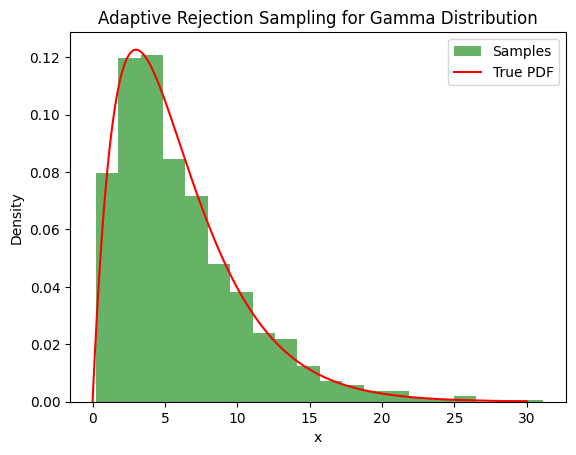

In [116]:
from scipy import stats

num_samples = 1000
f = lambda x: stats.gamma.pdf(x, a=2, scale = 3)

samples = ars(f, num_samples, burn_in = 1000, num_init_points = 10)

# Plot the results
plt.hist(samples, bins=20, density=True, alpha=0.6, color='g', label='Samples')

# Plot the true PDF for comparison
x_vals = np.linspace(0, 30, 1000)
y_vals = stats.gamma.pdf(x_vals, a=2, scale = 3)  # Normalized PDF
plt.plot(x_vals, y_vals, 'r-', label='True PDF')

plt.legend()
plt.title("Adaptive Rejection Sampling for Gamma Distribution")
plt.xlabel("x")
plt.ylabel("Density")
plt.show()